In [52]:
#default_exp tuning

# Tuning

<br>

### Imports

In [53]:
#exports
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor

from batopt import clean, discharge, charge

In [54]:
import FEAutils as hlp
import matplotlib.pyplot as plt

<br>

### User Inputs

In [55]:
intermediate_data_dir = '../data/intermediate'

<br>

### Preparing Data

First we'll load in the target and feature data for both the charging and discharging models

In [56]:
charge_x, charge_y = charge.prepare_training_input_data(intermediate_data_dir)
discharge_x, discharge_y = discharge.prepare_training_input_data(intermediate_data_dir)

charge_x.head()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,solar_7d_lag,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,weekend,hour,doy,dow
2017-11-10 05:00:00+00:00,12.190,12.07,11.880,11.29,13.37,13.43,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0,5.0,314,4
2017-11-10 05:30:00+00:00,12.145,12.13,11.745,11.20,13.44,13.52,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0,5.5,314,4
2017-11-10 06:00:00+00:00,12.100,12.19,11.610,11.11,13.51,13.61,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0,6.0,314,4
2017-11-10 06:30:00+00:00,11.985,12.05,11.315,10.85,13.52,13.62,0.00,0.48,0.55,0.52,0.915,0.575,0.66,0,6.5,314,4
2017-11-10 07:00:00+00:00,11.870,11.91,11.020,10.59,13.53,13.63,0.02,0.96,1.10,1.04,1.830,1.150,1.32,0,7.0,314,4


In [57]:
s_demand = clean.load_training_dataset(intermediate_data_dir, 'demand')['demand_MW']

s_demand.head()

datetime
2017-11-03 00:00:00+00:00    2.19
2017-11-03 00:30:00+00:00    2.14
2017-11-03 01:00:00+00:00    2.01
2017-11-03 01:30:00+00:00    1.87
2017-11-03 02:00:00+00:00    1.86
Freq: 30T, Name: demand_MW, dtype: float64

In [58]:
s_pv = clean.load_training_dataset(intermediate_data_dir, 'pv')['pv_power_mw']

s_pv.head()

datetime
2017-11-03 00:00:00+00:00    0.0
2017-11-03 00:30:00+00:00    0.0
2017-11-03 01:00:00+00:00    0.0
2017-11-03 01:30:00+00:00    0.0
2017-11-03 02:00:00+00:00    0.0
Freq: 30T, Name: pv_power_mw, dtype: float64

In [59]:
def get_train_test(arr, start_of_test_period): 
    train_arr = arr[:pd.to_datetime(start_of_test_period, utc=True)]
    test_arr = arr[pd.to_datetime(start_of_test_period, utc=True):]
    
    return train_arr, test_arr

start_of_test_period = '2018-09-15'

charge_x_train, charge_x_test = get_train_test(charge_x, start_of_test_period)
charge_y_train, charge_y_test = get_train_test(charge_y, start_of_test_period)
discharge_x_train, discharge_x_test = get_train_test(discharge_x, start_of_test_period)
discharge_y_train, discharge_y_test = get_train_test(discharge_y, start_of_test_period)

<br>

### Training & Evaluating Models

<AxesSubplot:>

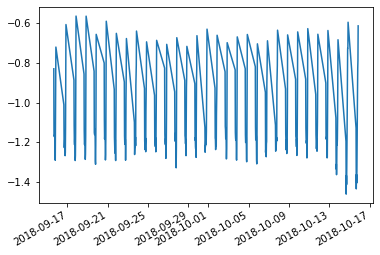

In [60]:
discharge_rf = RandomForestRegressor()

discharge_rf.fit(discharge_x_train, discharge_y_train)
discharge_y_pred = pd.Series(discharge_rf.predict(discharge_x_test), index=discharge_x_test.index)

discharge_y_pred.plot()

<AxesSubplot:>

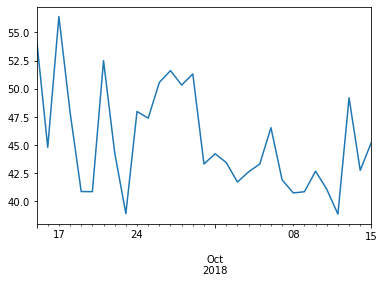

In [61]:
s_demand_test = s_demand.loc[discharge_y_pred.index]

s_old_peaks = s_demand_test.groupby(s_demand_test.index.date).max()
s_new_peaks = (s_demand_test+discharge_y_pred).groupby(s_demand_test.index.date).max()

s_pct_peak_reduction = 100*(s_old_peaks - s_new_peaks)/s_new_peaks
s_pct_peak_reduction.index = pd.to_datetime(s_pct_peak_reduction.index)

s_pct_peak_reduction.plot()

<AxesSubplot:>

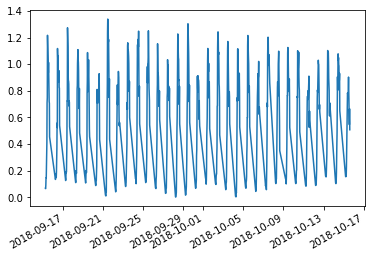

In [62]:
charge_rf = RandomForestRegressor()

charge_rf.fit(charge_x_train, charge_y_train)
charge_y_pred = pd.Series(charge_rf.predict(charge_x_test), index=charge_x_test.index)

charge_y_pred.plot()

<AxesSubplot:>

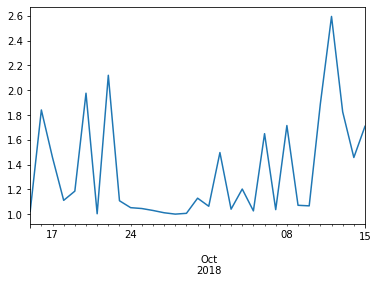

In [63]:
s_solar_charge_pct = (charge_y_pred - s_pv.loc[charge_y_pred.index]).clip(0).groupby(charge_y_pred.index.date).sum()/charge_y_pred.groupby(charge_y_pred.index.date).sum()
s_grid_charge_pct = 1 - s_solar_charge_pct

s_emissions_factor = 3*s_solar_charge_pct + 1*s_grid_charge_pct
s_emissions_factor.index = pd.to_datetime(s_emissions_factor.index)

s_emissions_factor.plot()

The average score was: 60.88


<AxesSubplot:>

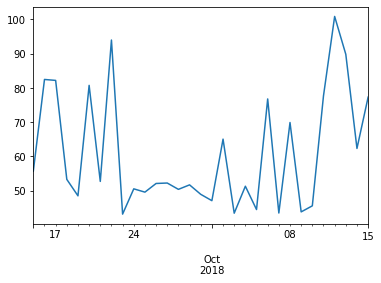

In [65]:
s_score = s_pct_peak_reduction*s_emissions_factor

print(f'The average score was: {round(s_score.mean(), 2)}')

s_score.plot()

Plotting the PV used to charge the battery against the potential (capped at 6 MWh per day) 

<AxesSubplot:>

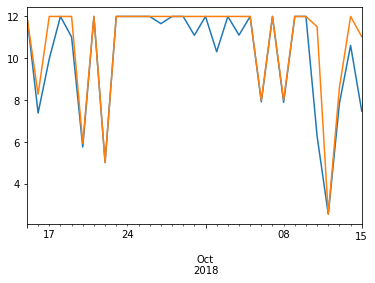

In [77]:
solar_charge = np.minimum(charge_y_pred, s_pv.loc[charge_y_pred.index])
day_solar_charge = solar_charge.groupby(solar_charge.index.date).sum().clip(0,12)
day_solar_charge.index = pd.to_datetime(day_solar_charge.index)

solar_potential = np.clip(s_pv.loc[charge_y_pred.index], 0, 2.5)
day_solar_potential = solar_potential.groupby(solar_potential.index.date).sum().clip(0,12)
day_solar_potential.index = pd.to_datetime(day_solar_potential.index)


day_solar_charge.plot()
day_solar_potential.plot()



Text(0, 0.5, '% exploited')

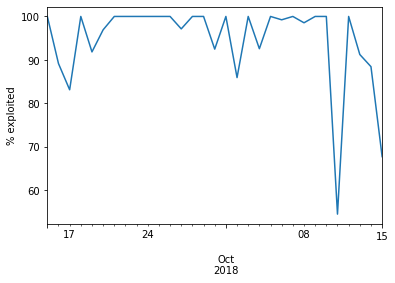

In [80]:
pct_exploit = 100 * day_solar_charge/day_solar_potential
pct_exploit.plot()
plt.ylabel('% exploited')

<br>

Finally we'll export the relevant code to our `batopt` module

In [14]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-cleaning.ipynb.
Converted 02-discharging.ipynb.
Converted 03-charging.ipynb.
Converted 04-constraints.ipynb.
Converted 05-tuning.ipynb.
Converted 06-pipeline.ipynb.
Converted 07-charging-nn.ipynb.
